In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2e-20

nband = 120

ng =7

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 980

data w_diffuse
     &     /1.6 , 1.75 , 1.55 , 1.66,
     &     1.66 , 1.66 , 1.66/

data wgt
     &     /0.35 , 0.6 , 0.5 , 0.55,
     &     0.7 , 0.9 , 1.0/

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

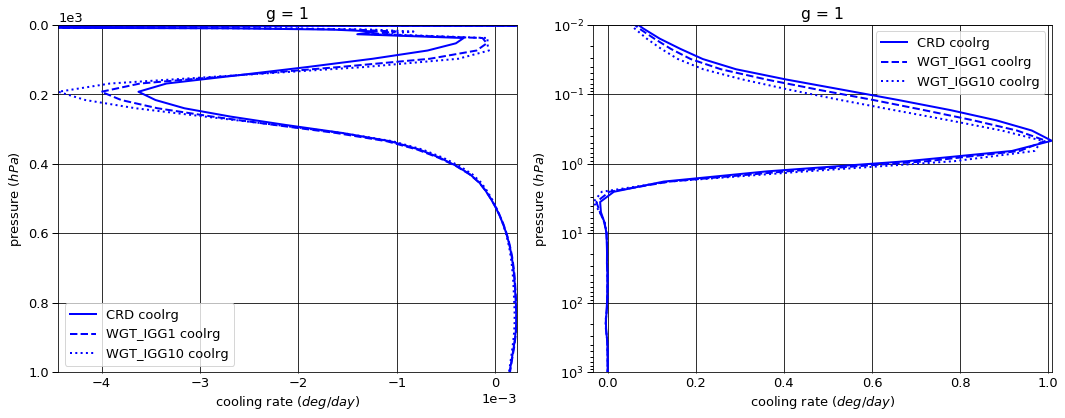

# Figure: cooling rate g-group 2

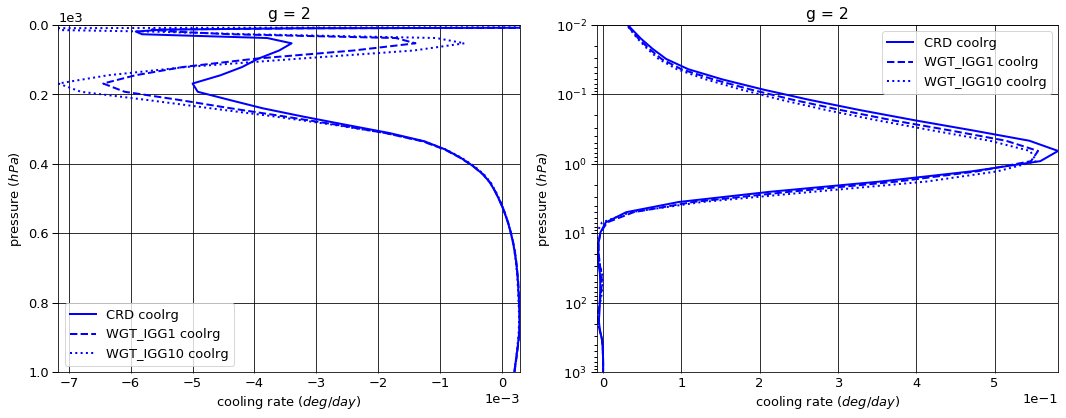

# Figure: cooling rate g-group 3

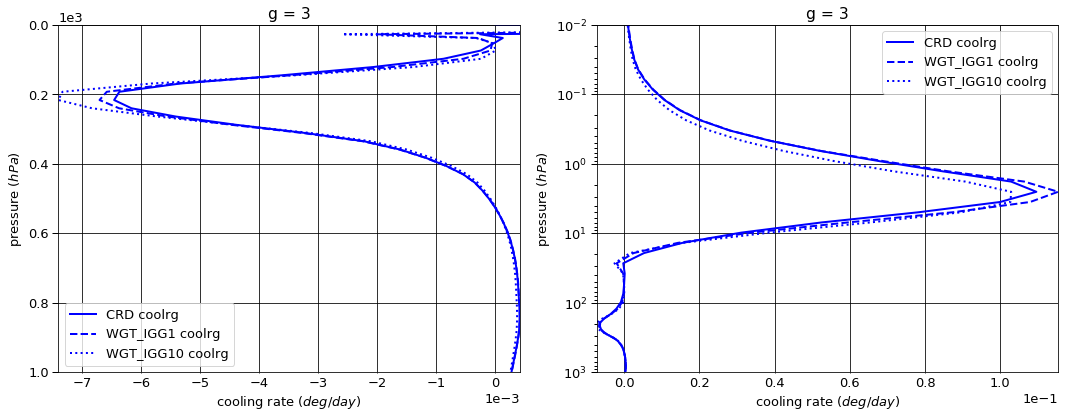

# Figure: cooling rate g-group 4

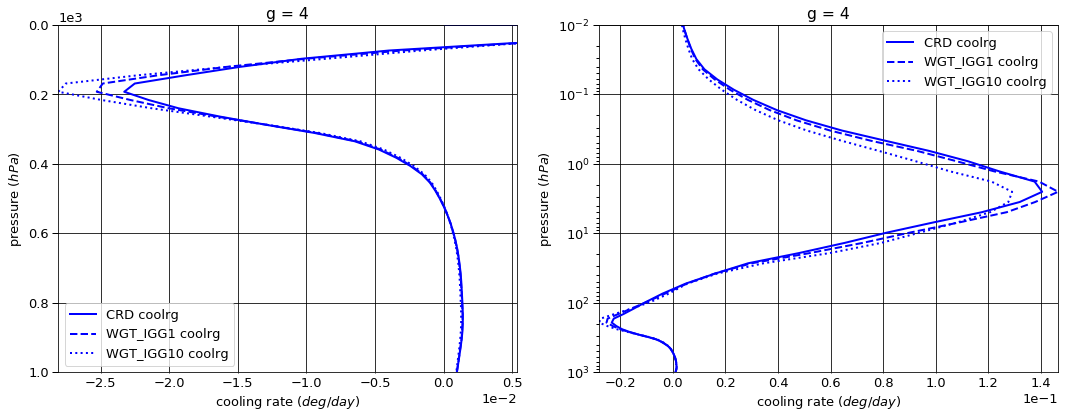

# Figure: cooling rate g-group 5

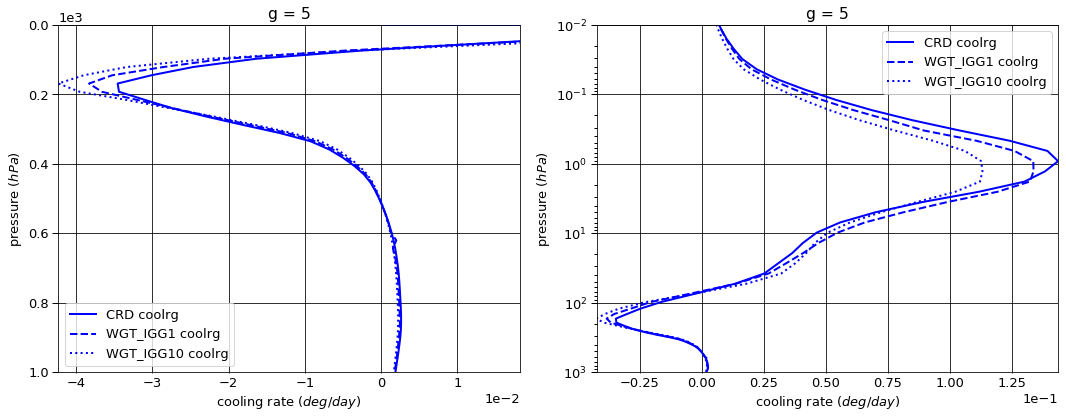

# Figure: cooling rate g-group 6

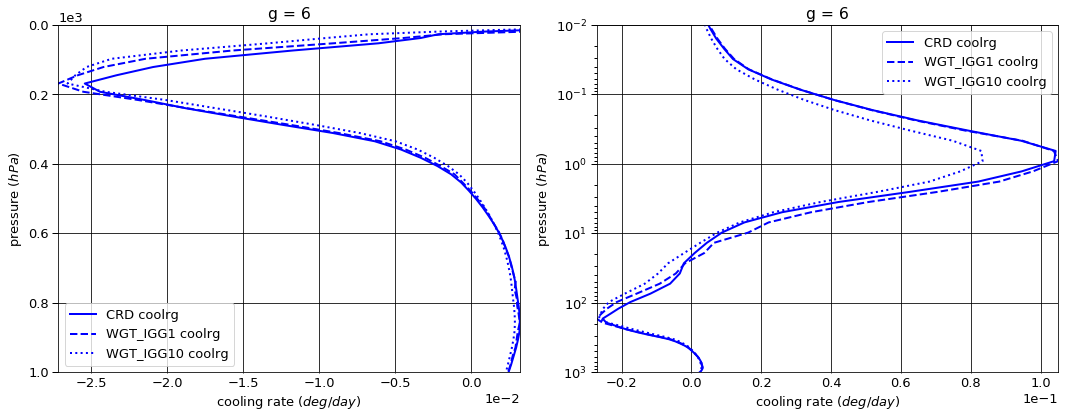

# Figure: cooling rate g-group 7

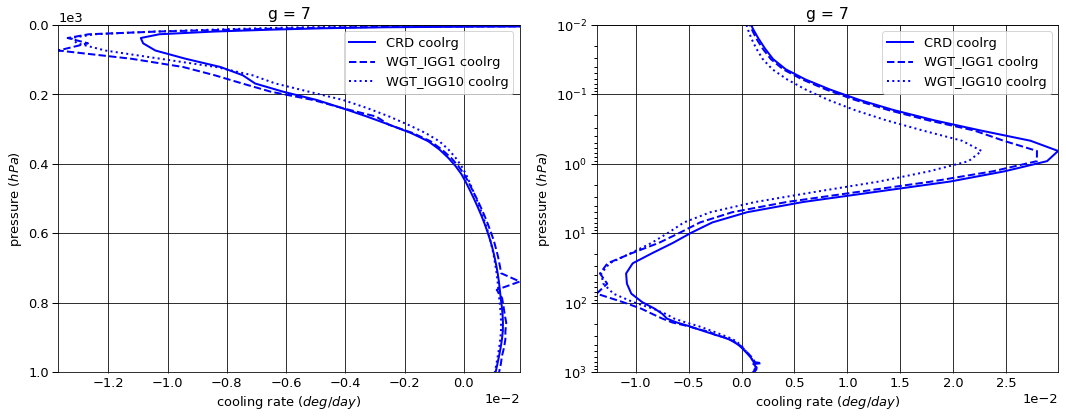

# Figure: cooling rate g-group total

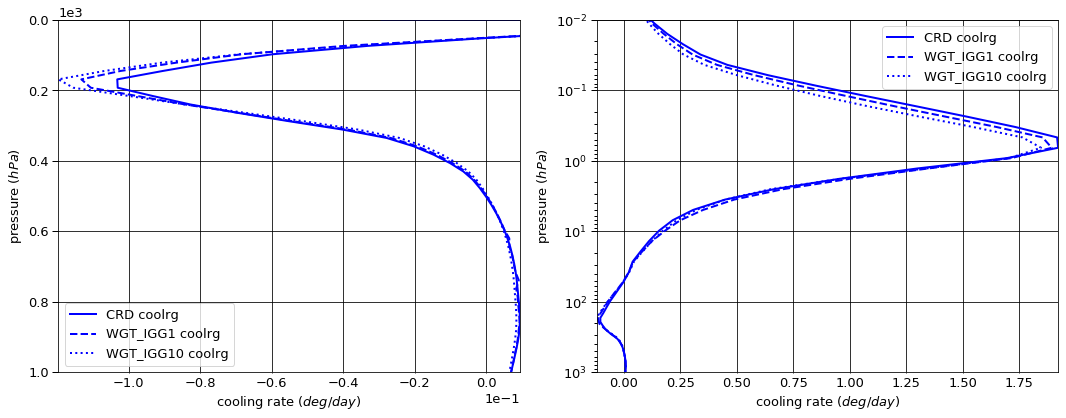

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.118328  0.000000 -0.118328
  1013.0   76    -0.141020  0.064601 -0.076419
2 0.0      1     -0.147398  0.000000 -0.147398
  1013.0   76    -0.244165  0.103549 -0.140616
3 0.0      1     -0.098606  0.000000 -0.098606
  1013.0   76    -0.243896  0.116540 -0.127357
4 0.0      1     -0.341628  0.000000 -0.341628
  1013.0   76    -0.986747  0.440217 -0.546530
5 0.0      1     -0.854888  0.000000 -0.854888
  1013.0   76    -2.115042  0.828293 -1.286749
6 0.0      1     -2.202812  0.000000 -2.202812
  1013.0   76    -3.538126  0.895104 -2.643022
7 0.0      1     -7.243729  0.000000 -7.243729
  1013.0   76    -7.782411  0.357042 -7.425369


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.119060  0.000000 -0.119060
  1013.0   76    -0.141020  0.064951 -0.076068
2 0.0      1     -0.146417  0.000000 -0.146417
  1013.0   76    -0.244165  0.104733 -0.139432
3 0.0      1     -0.099936  0.000000 -0.099936
  1013.0   76    -0.243896  0.116673 -0.127223
4 0.0      1     -0.337921  0.000000 -0.337921
  1013.0   76    -0.986747  0.440083 -0.546664
5 0.0      1     -0.816420  0.000000 -0.816420
  1013.0   76    -2.115042  0.833711 -1.281331
6 0.0      1     -2.136652  0.000000 -2.136652
  1013.0   76    -3.538126  0.925310 -2.612816
7 0.0      1     -7.177973  0.000000 -7.177973
  1013.0   76    -7.782411  0.395577 -7.386834


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.119915  0.000000 -0.119915
  1013.0   76    -0.141020  0.063214 -0.077806
2 0.0      1     -0.148477  0.000000 -0.148477
  1013.0   76    -0.244165  0.103877 -0.140288
3 0.0      1     -0.098160  0.000000 -0.098160
  1013.0   76    -0.243896  0.112695 -0.131201
4 0.0      1     -0.333889  0.000000 -0.333889
  1013.0   76    -0.986747  0.431954 -0.554793
5 0.0      1     -0.773089  0.000000 -0.773089
  1013.0   76    -2.115042  0.836376 -1.278666
6 0.0      1     -2.107889  0.000000 -2.107889
  1013.0   76    -3.538126  0.920657 -2.617469
7 0.0      1     -7.241572  0.000000 -7.241572
  1013.0   76    -7.782411  0.351762 -7.430649


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -7.327500e-04  0.000000 -0.000733
  1013.0   76     0.000000e+00  0.000350  0.000350
2 0.0      1      9.808500e-04  0.000000  0.000981
  1013.0   76     0.000000e+00  0.001184  0.001184
3 0.0      1     -1.330208e-03  0.000000 -0.001330
  1013.0   76     0.000000e+00  0.000134  0.000134
4 0.0      1      3.707050e-03  0.000000  0.003707
  1013.0   76     0.000000e+00 -0.000134 -0.000134
5 0.0      1      3.846740e-02  0.000000  0.038467
  1013.0   76     0.000000e+00  0.005418  0.005418
6 0.0      1      6.615950e-02  0.000000  0.066159
  1013.0   76     0.000000e+00  0.030206  0.030206
7 0.0      1      6.575650e-02  0.000000  0.065757
  1013.0   76     8.881784e-16  0.038535  0.038535


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.587650e-03  0.000000 -0.001588
  1013.0   76     0.000000e+00 -0.001387 -0.001387
2 0.0      1     -1.079490e-03  0.000000 -0.001079
  1013.0   76     0.000000e+00  0.000328  0.000328
3 0.0      1      4.457400e-04  0.000000  0.000446
  1013.0   76     0.000000e+00 -0.003845 -0.003845
4 0.0      1      7.738760e-03  0.000000  0.007739
  1013.0   76     0.000000e+00 -0.008263 -0.008263
5 0.0      1      8.179878e-02  0.000000  0.081799
  1013.0   76     0.000000e+00  0.008083  0.008083
6 0.0      1      9.492260e-02  0.000000  0.094923
  1013.0   76     0.000000e+00  0.025553  0.025553
7 0.0      1      2.157200e-03  0.000000  0.002157
  1013.0   76     8.881784e-16 -0.005280 -0.005280

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.026563
  1001.112500 75     0.000145
2 0.000312    1     -0.002474
  1001.112500 75     0.000201
3 0.000312    1      0.000012
  1001.112500 75     0.000282
4 0.000312    1      0.000095
  1001.112500 75     0.000971
5 0.000312    1      0.000143
  1001.112500 75     0.001869
6 0.000312    1     -0.000078
  1001.112500 75     0.002442
7 0.000312    1     -0.000144
  1001.112500 75     0.001074


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.020412
  1001.112500 75     0.000150
2 0.000312    1     -0.001545
  1001.112500 75     0.000207
3 0.000312    1      0.000031
  1001.112500 75     0.000286
4 0.000312    1      0.000197
  1001.112500 75     0.000965
5 0.000312    1      0.000355
  1001.112500 75     0.001779
6 0.000312    1      0.000061
  1001.112500 75     0.002414
7 0.000312    1     -0.000180
  1001.112500 75     0.001190


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.015550
  1001.112500 75     0.000140
2 0.000312    1     -0.000547
  1001.112500 75     0.000204
3 0.000312    1      0.000035
  1001.112500 75     0.000265
4 0.000312    1      0.000193
  1001.112500 75     0.000927
5 0.000312    1      0.000316
  1001.112500 75     0.001659
6 0.000312    1     -0.000035
  1001.112500 75     0.002270
7 0.000312    1     -0.000189
  1001.112500 75     0.001049


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.006151
  1001.112500 75     0.000004
2 0.000312    1      0.000929
  1001.112500 75     0.000006
3 0.000312    1      0.000019
  1001.112500 75     0.000004
4 0.000312    1      0.000102
  1001.112500 75    -0.000006
5 0.000312    1      0.000212
  1001.112500 75    -0.000090
6 0.000312    1      0.000139
  1001.112500 75    -0.000028
7 0.000312    1     -0.000036
  1001.112500 75     0.000116


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.011013
  1001.112500 75    -0.000005
2 0.000312    1      0.001928
  1001.112500 75     0.000002
3 0.000312    1      0.000023
  1001.112500 75    -0.000017
4 0.000312    1      0.000098
  1001.112500 75    -0.000044
5 0.000312    1      0.000174
  1001.112500 75    -0.000210
6 0.000312    1      0.000043
  1001.112500 75    -0.000171
7 0.000312    1     -0.000045
  1001.112500 75    -0.000025

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-11.007387,0.000000,-11.007387
1013.0,76,-15.051406,2.805346,-12.246061



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.834379,0.000000,-10.834379
1013.0,76,-15.051406,2.881039,-12.170368



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.822991,0.000000,-10.822991
1013.0,76,-15.051406,2.820535,-12.230872



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.730083e-01,0.000000,0.173008
1013.0,76,1.776357e-15,0.075693,0.075693



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.843959e-01,0.000000,0.184396
1013.0,76,1.776357e-15,0.015189,0.015189


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.029010
1001.112500,75,0.006984



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.021495
1001.112500,75,0.006990



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.015776
1001.112500,75,0.006513



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.007515
1001.112500,75,0.000006



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.013234
1001.112500,75,-0.000470


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.009375,0.009365
2,0.016083,0.016227
3,0.016292,0.016195
4,0.065542,0.065542
5,0.139458,0.140541
6,0.230792,0.235277
7,0.522458,0.516853


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.739131e-18
2,6.037014e-19
3,9.917477e-19
4,2.699552e-19
5,7.348223e-20
6,2.000197e-20
7,1.127665e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.739131e-18,NaN,0.009375,0.009365,0.009375,0.009365,1.0
2,6.037014e-19,0.161455,0.016083,0.016227,0.025458,0.025592,1.0
3,9.917477e-19,1.642779,0.016292,0.016195,0.041750,0.041787,50.0
4,2.699552e-19,0.272202,0.065542,0.065542,0.107292,0.107329,50.0
5,7.348223e-20,0.272202,0.139458,0.140541,0.246750,0.247870,50.0
6,2.000197e-20,0.272202,0.230792,0.235277,0.477542,0.483147,50.0
7,1.127665e-22,0.005638,0.522458,0.516853,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.033999e-17  7.294197e-18   1.417563  1.792409e-05
      2 0.000312     1.280713e-18  8.614404e-19   1.486711  2.386249e-06
      3 0.000312     2.021732e-20  1.935323e-20   1.044648  4.241908e-08
      4 0.000312     2.004212e-20  1.507244e-20   1.329720  3.817507e-08
      5 0.000312     1.832796e-20  8.374455e-21   2.188555  3.289262e-08
      6 0.000312     8.880927e-21  3.441365e-21   2.580641  1.787424e-08
      7 0.000312     1.382272e-21  5.162000e-23  26.777846  2.963554e-09
2     1 0.000750     1.031259e-17  7.305359e-18   1.411647  8.398527e-06
      2 0.000750     1.291072e-18  8.701907e-19   1.483666  1.128178e-06
      3 0.000750     2.079139e-20  1.988964e-20   1.045338  2.043942e-08
      4 0.000750     2.041858e-20  1.532837e-20   1.332077  1.821613e-08
      5 0.000750     1.866587e-20  8.466445e-21   2.204688  1.568192e-08
      6 0.000750     9.042284e-21  3.481952e-21   2.596901  8.527512e-09
      7 0.000750     1.402658e-21  5.228812e-23  26.825569  1.409478e-09
3     1 0.001052     1.025677e-17  7.326231e-18   1.400006  1.512852e-05
      2 0.001052     1.311950e-18  8.877837e-19   1.477782  2.069113e-06
      3 0.001052     2.191116e-20  2.093123e-20   1.046817  3.880198e-08
      4 0.001052     2.118491e-20  1.584080e-20   1.337364  3.401787e-08
      5 0.001052     1.936312e-20  8.651405e-21   2.238147  2.925311e-08
      6 0.001052     9.378507e-21  3.564234e-21   2.631283  1.593488e-08
      7 0.001052     1.445736e-21  5.360061e-23  26.972373  2.618780e-09
4     1 0.001476     1.019899e-17  7.344932e-18   1.388575  2.602713e-05
      2 0.001476     1.333106e-18  9.056226e-19   1.472032  3.624998e-06
      3 0.001476     2.310287e-20  2.203755e-20   1.048341  7.040366e-08
      4 0.001476     2.199070e-20  1.637361e-20   1.343058  6.071132e-08
      5 0.001476     2.009253e-20  8.841165e-21   2.272611  5.214601e-08
      6 0.001476     9.733899e-21  3.648880e-21   2.667640  2.846501e-08
      7 0.001476     1.492136e-21  5.496778e-23  27.145640  4.654445e-09
5     1 0.002070     1.013996e-17  7.361156e-18   1.377495  4.337429e-05
      2 0.002070     1.354258e-18  9.234738e-19   1.466483  6.151622e-06
      3 0.002070     2.435929e-20  2.320184e-20   1.049886  1.237698e-07
      4 0.002070     2.282798e-20  1.692132e-20   1.349066  1.049780e-07
      5 0.002070     2.084583e-20  9.033681e-21   2.307567  9.005202e-08
      6 0.002070     1.010475e-20  3.734912e-21   2.705485  4.927652e-08
      7 0.002070     1.541488e-21  5.637920e-23  27.341435  8.022925e-09
6     1 0.002904     1.007965e-17  7.374875e-18   1.366755  7.067547e-05
      2 0.002904     1.375391e-18  9.413266e-19   1.461120  1.020668e-05
      3 0.002904     2.568863e-20  2.443176e-20   1.051444  2.128380e-07
      4 0.002904     2.369857e-20  1.748515e-20   1.355354  1.775267e-07
      5 0.002904     2.162340e-20  9.229298e-21   2.342909  1.520699e-07
      6 0.002904     1.049150e-20  3.822405e-21   2.744738  8.344092e-08
      7 0.002904     1.593955e-21  5.784279e-23  27.556682  1.353757e-08
7     1 0.004074     1.001698e-17  7.385431e-18   1.356317  1.131742e-04
      2 0.004074     1.396342e-18  9.591007e-19   1.455887  1.664198e-05
      3 0.004074     2.709912e-20  2.573521e-20   1.052998  3.599291e-07
      4 0.004074     2.460234e-20  1.806548e-20   1.361842  2.951238e-07
      5 0.004074     2.242337e-20  9.427993e-21   2.378382  2.523964e-07
      6 0.004074     1.089346e-20  3.911277e-21   2.785141  1.389083e-07
      7 0.004074     1.649533e-21  5.936795e-23  27.784912  2.247459e-08
8     1 0.005714     9.950742e-18  7.392073e-18   1.346137  1.787437e-04
      2 0.005714     1.416930e-18  9.767079e-19   1.450720  2.676194e-05
      3 0.005714     2.860227e-20  2.712328e-20   1.054529  6.009327e-07
      4 0.005714     2.553940e-20  1.866324e-20   1.368434  4.840872e-07
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
